In [18]:
# -*- coding: utf-8 -*-

In [1]:
__updated__ = '2022-03-23 07:37:31'
from Calculator import Calculator as Calc
from PlotTools import createPlot, CreateRecommendFig
from utils import (
    pd, np, getSchema, getDateBeforeTrade, 
    saveRecommand, timedelta, GetException,
    sendResultTable, VolumeFilter, PriceFilter,
    changedType, datetime, os, parent,createRecommandTable
)

import warnings
warnings.filterwarnings("ignore")

c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


In [40]:

highProbTable = pd.read_csv(os.path.join(parent, "無腦交易","Output\HundredBreakOutL","Summary_prob_holding_tradenum.csv"), encoding='utf-8-sig')
bt_sum_Table = pd.read_csv(os.path.join(parent, "無腦交易","Output\HundredBreakOutL","Summary.csv"), encoding='utf-8-sig')


def main(td = datetime.today(), min_price=0, max_price=50, num_shares=10000, shares_ratio=0):
    try:
        # setup date
        # now = datetime.now()
        td, last = getDateBeforeTrade(td.replace(hour=18))
        # setup data
        schema = getSchema('TWSE')
        table = schema['StockList']
        last_date = sorted(table.distinct("UpdateDate"))[-1]
        info_data = dict((x['Ticker'], x['Industry']+f"({x['Market'][-1]})") for x in table.find({"UpdateDate":{"$eq":last_date}, "Industry" :{"$ne":""}}))
        
        schema = getSchema('TWSE')
        table = schema['historicalPrice']
        final_select = []
        pre_3y = td + timedelta(-365*1)
        momentums = []
        highProb = []
        bt_Prob = []
        holding_p = []
        for ticker in info_data.keys():#df.Ticker.unique():
            try:
                temp_df = pd.DataFrame(list(table.find({'Ticker':{'$eq':ticker},'Date':{'$gte':pre_3y.strftime('%Y-%m-%d'), '$lte':td.strftime('%Y-%m-%d')}})))#.set_index('Date')
                if temp_df is None:
                    print(ticker, 'is None', temp_df)
                    continue
                if temp_df.empty:
                    print(ticker, 'is empty', temp_df)
                    continue
                for col in 'Open,High,Low,Close,Volume'.split(','):
                    temp_df[col] = temp_df[col].apply(changedType)
                temp_df = temp_df.set_index("Date")
                
                # temp_df['Adj V'] = temp_df.Volume.apply(lambda x: int(x/1000))
                
                p_condition = temp_df.Close.iloc[-1] < temp_df.Close.iloc[-101:-1].min()
                if p_condition and bt_sum_Table[bt_sum_Table.代號==ticker]['總交易次數'].values[0] >= 10 and bt_sum_Table[bt_sum_Table.代號==ticker]['勝率%'].values[0] > 50:
                    final_select.append(ticker)
                    if ticker in highProbTable.代號:
                        highProb.append((ticker, 'Y'))
                    bt_Prob.append((ticker, bt_sum_Table[bt_sum_Table.代號==ticker]['勝率%'].values[0]))
                    holding_p.append((ticker, bt_sum_Table[bt_sum_Table.代號==ticker]['平均持倉時間(日)'].values[0]))
                    # momentums.append((ticker, Calc.Momemtum(temp_df)))
            except KeyboardInterrupt:
                import os
                os._exit(0)
            except:
                print(f'Ticker : {ticker}\t Error :', GetException())
        
        description = '無腦秘書1'
        entry_method = '選出後隔日開盤進場'
        # expand_text = "波段交易，停利停損皆10%"
        saveRecommand(final_select, 'HundrenBreakoutL')
        print(len(final_select), final_select)
#         CreateRecommendFig(td, final_select, bt_Prob=bt_Prob, holding_p=holding_p, highProb=highProb, 
#                         algo_num=1, description=description, entry_method=entry_method, take_profit_rate=10, 
#                         stop_loss_rate=10, algo_name='HundrenBreakoutL')
        return td, final_select, bt_Prob, holding_p, highProb
#                         algo_num=1, description=description, entry_method=entry_method, take_profit_rate=10, 
#                         stop_loss_rate=10, algo_name='HundrenBreakoutL'
        # print(createRecommandTable(final_select, bt_Prob=bt_Prob, holding_p=holding_p, highProb=highProb))
        # sendResultTable(td, final_select, bt_Prob=bt_Prob, holding_p=holding_p, highProb=highProb, algo_num=1, expand_text=expand_text, useTele=False)#, token='hDvo7h5atlmcshug48REUqOBv1nHzm1fb6YZ9I0ZNu9')
    except:
        # print(f'ticker : {ticker}\t Error : ',GetException())
        print(f'Error : ',GetException())
    
    

In [41]:

from Calculator import Calculator
from utils import (
    fig_path, os, sendPhoto, GetException,
    plt, mpf, gridspec, mpl_ticker, 
    datetime, timedelta, date2num,
    mcolors, LineCollection, PolyCollection,
    TICKLEFT, TICKRIGHT, Line2D,
    Rectangle, Affine2D, xrange, fig_path
)
from matplotlib.font_manager import fontManager, FontProperties
ChineseFont = FontProperties([f.name for f in fontManager.ttflist if 'JhengHei' in f.name or 'Heiti' in f.name][0]) #  or 'Arial' in f.name
import matplotlib
def CreateRecommendFig(td, tickers, bt_Prob=[], holding_p=[], highProb=[], 
                        algo_num=1, description='', entry_method='', take_profit_rate=10, 
                        stop_loss_rate=10, algo_name=''):
    """
    產生選股建議全表
    """
    tmp_h_prob = dict(highProb)
    tmp_bt_prob = dict(bt_Prob)
    tmp_holing_p = dict(holding_p)
    h_prob = [tmp_h_prob.get(ticker, "N") for ticker in tickers] # high win probability
    bt_prob = [round(tmp_bt_prob.get(ticker, 0), 2) for ticker in tickers]  # backtest win probability
    h_p = [round(tmp_holing_p.get(ticker, 0),2) for ticker in tickers] # holding period
    return PlotResult(td, tickers, bt_prob, h_p, h_prob, algo_num, description, entry_method, take_profit_rate, stop_loss_rate, algo_name)


def PlotResult(dt:datetime.today(), tickers=[], bt_Prob=[], holding_p=[], highProb=[], algo_num=1, 
                description='', entry_method='', take_profit_rate=10, stop_loss_rate=10,
                algo_name=''):
    try:
        if not tickers: return ''
        # Create Figure
        fig = plt.figure(figsize=(10, 14), dpi=600)
        # fig.set_size_inches(1024,864)
        # set axis to be Clear
        plt.yticks([])
        plt.xticks([])
        # set title
        dtStr = dt.strftime("%Y-%m-%d")
        fig.suptitle(f'無腦秘書{algo_num}號 {dtStr} 選股建議', fontproperties=ChineseFont)

        gs = gridspec.GridSpec(3, 3, wspace=0.25, hspace=0.25)
        # Plot Recommand Table
        ax1 = plt.subplot(gs[:2, :])
#         ax1.title.set_text(f'{dtStr} 選股建議')
#         ax1.title.set_font_properties(ChineseFont)
        setuptitle(ax1)
        PlotTable_v2(ax1, tickers, bt_Prob, holding_p, highProb)

        # Plot Description
        ax3 = plt.subplot(gs[2:, :])
        ax3.title.set_text('選股使用說明')
        ax3.title.set_font_properties(ChineseFont)
        PlotDiscriptionTXT(ax3, description, entry_method, take_profit_rate, stop_loss_rate)
    except:
        print(GetException())
    else:
        # dt = datetime.today()
        # fig_path = os.path.join(output_path, str(dt.year).zfill(
        #     4), str(dt.month).zfill(2), str(dt.day).zfill(2))
        if not os.path.isdir(fig_path):
            os.makedirs(fig_path)
        plt.tight_layout()
        plt.savefig(os.path.join(
            fig_path, f'{algo_name} Stock Suggestion.jpg'))
        plt.show()#block=False)
#         plt.close()
        return os.path.join(fig_path, f'{algo_name} Stock Suggestion.jpg')

def PlotTable_v2(ax, tickers, bt_Prob=[], holding_p=[], highProb=[], split_num=25):
    try:
        data = []
        tmp_d = zip(tickers, bt_Prob, holding_p, highProb)
        if len(tickers)>=split_num*2:
            if len([x for x in highProb if x == 'Y']):
                tmp_d = [x for x in tmp_d if x[-1] == 'Y']
            else:
                tmp_d = [x for x in tmp_d if x[-2] <= 40]
        seperate_num = int(len(tickers) / split_num)
        for i, (ticker, bt_p, hold_p, high_p) in enumerate(tmp_d):
            if i >= split_num:
                data[i-25].extend([ticker, bt_p, hold_p, high_p])
            else:
                data.append([ticker, bt_p, hold_p, high_p])

#         columns = ['回測勝率','平均持倉時間(日)','高勝率低持倉推薦']
        columns = ['代號','回測勝率','平均持倉時間(日)','高勝率低週期推薦'] * (seperate_num + 1)
        rows = tickers
        the_table = ax.table(cellText=data,
                                rowLabels=list(range(1, min(25, len(tickers)) + 1)),
                                colLabels=columns,
                                loc='center',
                                fontsize=16,
                                cellLoc='center',
                                rowLoc='center',
                                colLoc='center',
                                colWidths=[.1, ]*len(columns),
                                )
        
        table_props = the_table.properties()
        table_cells = table_props['children']
        for i, cell in enumerate(table_cells):
#             if not i:
#                 help(cell.set_text_props)
            cell.set_height(0.03)
            cell.set_text_props(fontproperties=ChineseFont, fontsize=16)

        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax.set_ylabel('')
        ax.set_xlabel('')
    except:
        print("PlotTable_v2 :",GetException())

def setuptitle(ax):
    ax.spines['top'].set_visible(False)  # .set_linewidth(2.0)
    ax.spines['bottom'].set_visible(False)  # .set_linewidth(2.0)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.set_ylabel('')
    ax.set_xlabel('')


def PlotDiscriptionTXT(ax, description, entry_method, take_profit_rate=10, stop_loss_rate=10):
    try:
        ax.text(4.6, 18, f'選股說明 : ',
                fontsize=11, horizontalalignment='right', fontweight='bold', fontproperties=ChineseFont)
        ax.text(4.8, 18, f'{description}',
                fontsize=11, horizontalalignment='left', fontweight='bold', fontproperties=ChineseFont)
        
        ax.text(4.6, 16, f'進場方式 : ', fontsize=11,
                horizontalalignment='right', fontproperties=ChineseFont)
        ax.text(4.8, 16, f'{entry_method}', fontsize=11,
                horizontalalignment='left', fontproperties=ChineseFont)
        
        # Describe Max Return Portfolio
        ax.text(4.6, 14, f'出場方式-停利 : ',
                fontsize=11, horizontalalignment='right', fontweight='bold', fontproperties=ChineseFont)
        ax.text(4.8, 14, f'{take_profit_rate}%',
                fontsize=11, horizontalalignment='left', fontweight='bold', fontproperties=ChineseFont)
        
        ax.text(4.6, 12, f'出場方式-停損 : ',
                fontsize=11, horizontalalignment='right', fontproperties=ChineseFont)
        ax.text(4.8, 12, f'{stop_loss_rate}%',
                fontsize=11, horizontalalignment='left', fontproperties=ChineseFont)
        
        # Describe Min Std Portfolio
        ax.text(4.6, 10, '備註 : ',
                fontsize=11, horizontalalignment='right', fontweight='bold', fontproperties=ChineseFont)
        ax.text(4.8, 10, '此選股尚未考慮除權息，若遇除權息打到停損，請等填息再出場(股價回到除權息前的價格)',
                fontsize=11, horizontalalignment='left', fontweight='bold', fontproperties=ChineseFont)
        ax.text(4.8, 8, '推薦欄為Y者，屬於低週期高勝率，且10年內有20次以上的交易次數(年均2次)，優先選擇',
                fontsize=11, horizontalalignment='left', fontweight='bold', fontproperties=ChineseFont)
        ax.text(4.8, 6, '推薦欄為N者，但想入場，建議同樣選擇低週期高勝率之標的',
                fontsize=11, horizontalalignment='left', fontweight='bold', fontproperties=ChineseFont)
        ax.text(4.8, 4, '所選標的皆已排除10年內交易次數少於10次之標的(沒人玩)',
                fontsize=11, horizontalalignment='left', fontweight='bold', fontproperties=ChineseFont)

        ax.spines['top'].set_linewidth(2.0)
        ax.spines['bottom'].set_linewidth(2.0)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.axis([0, 20, 0, 20])
    except:
        print(GetException())

In [18]:
['1','2'] * 1

['1', '2']

In [42]:
td, final_select, bt_Prob, holding_p, highProb = main()

16 ['2102', '2115', '2347', '2429', '3257', '4927', '6172', '8463', '9940', '1593', '4416', '5514', '6198', '6560', '6679', '8444']


In [31]:
description = '無腦秘書1-收破百日最低收盤'
entry_method = '選出後隔日開盤進場'

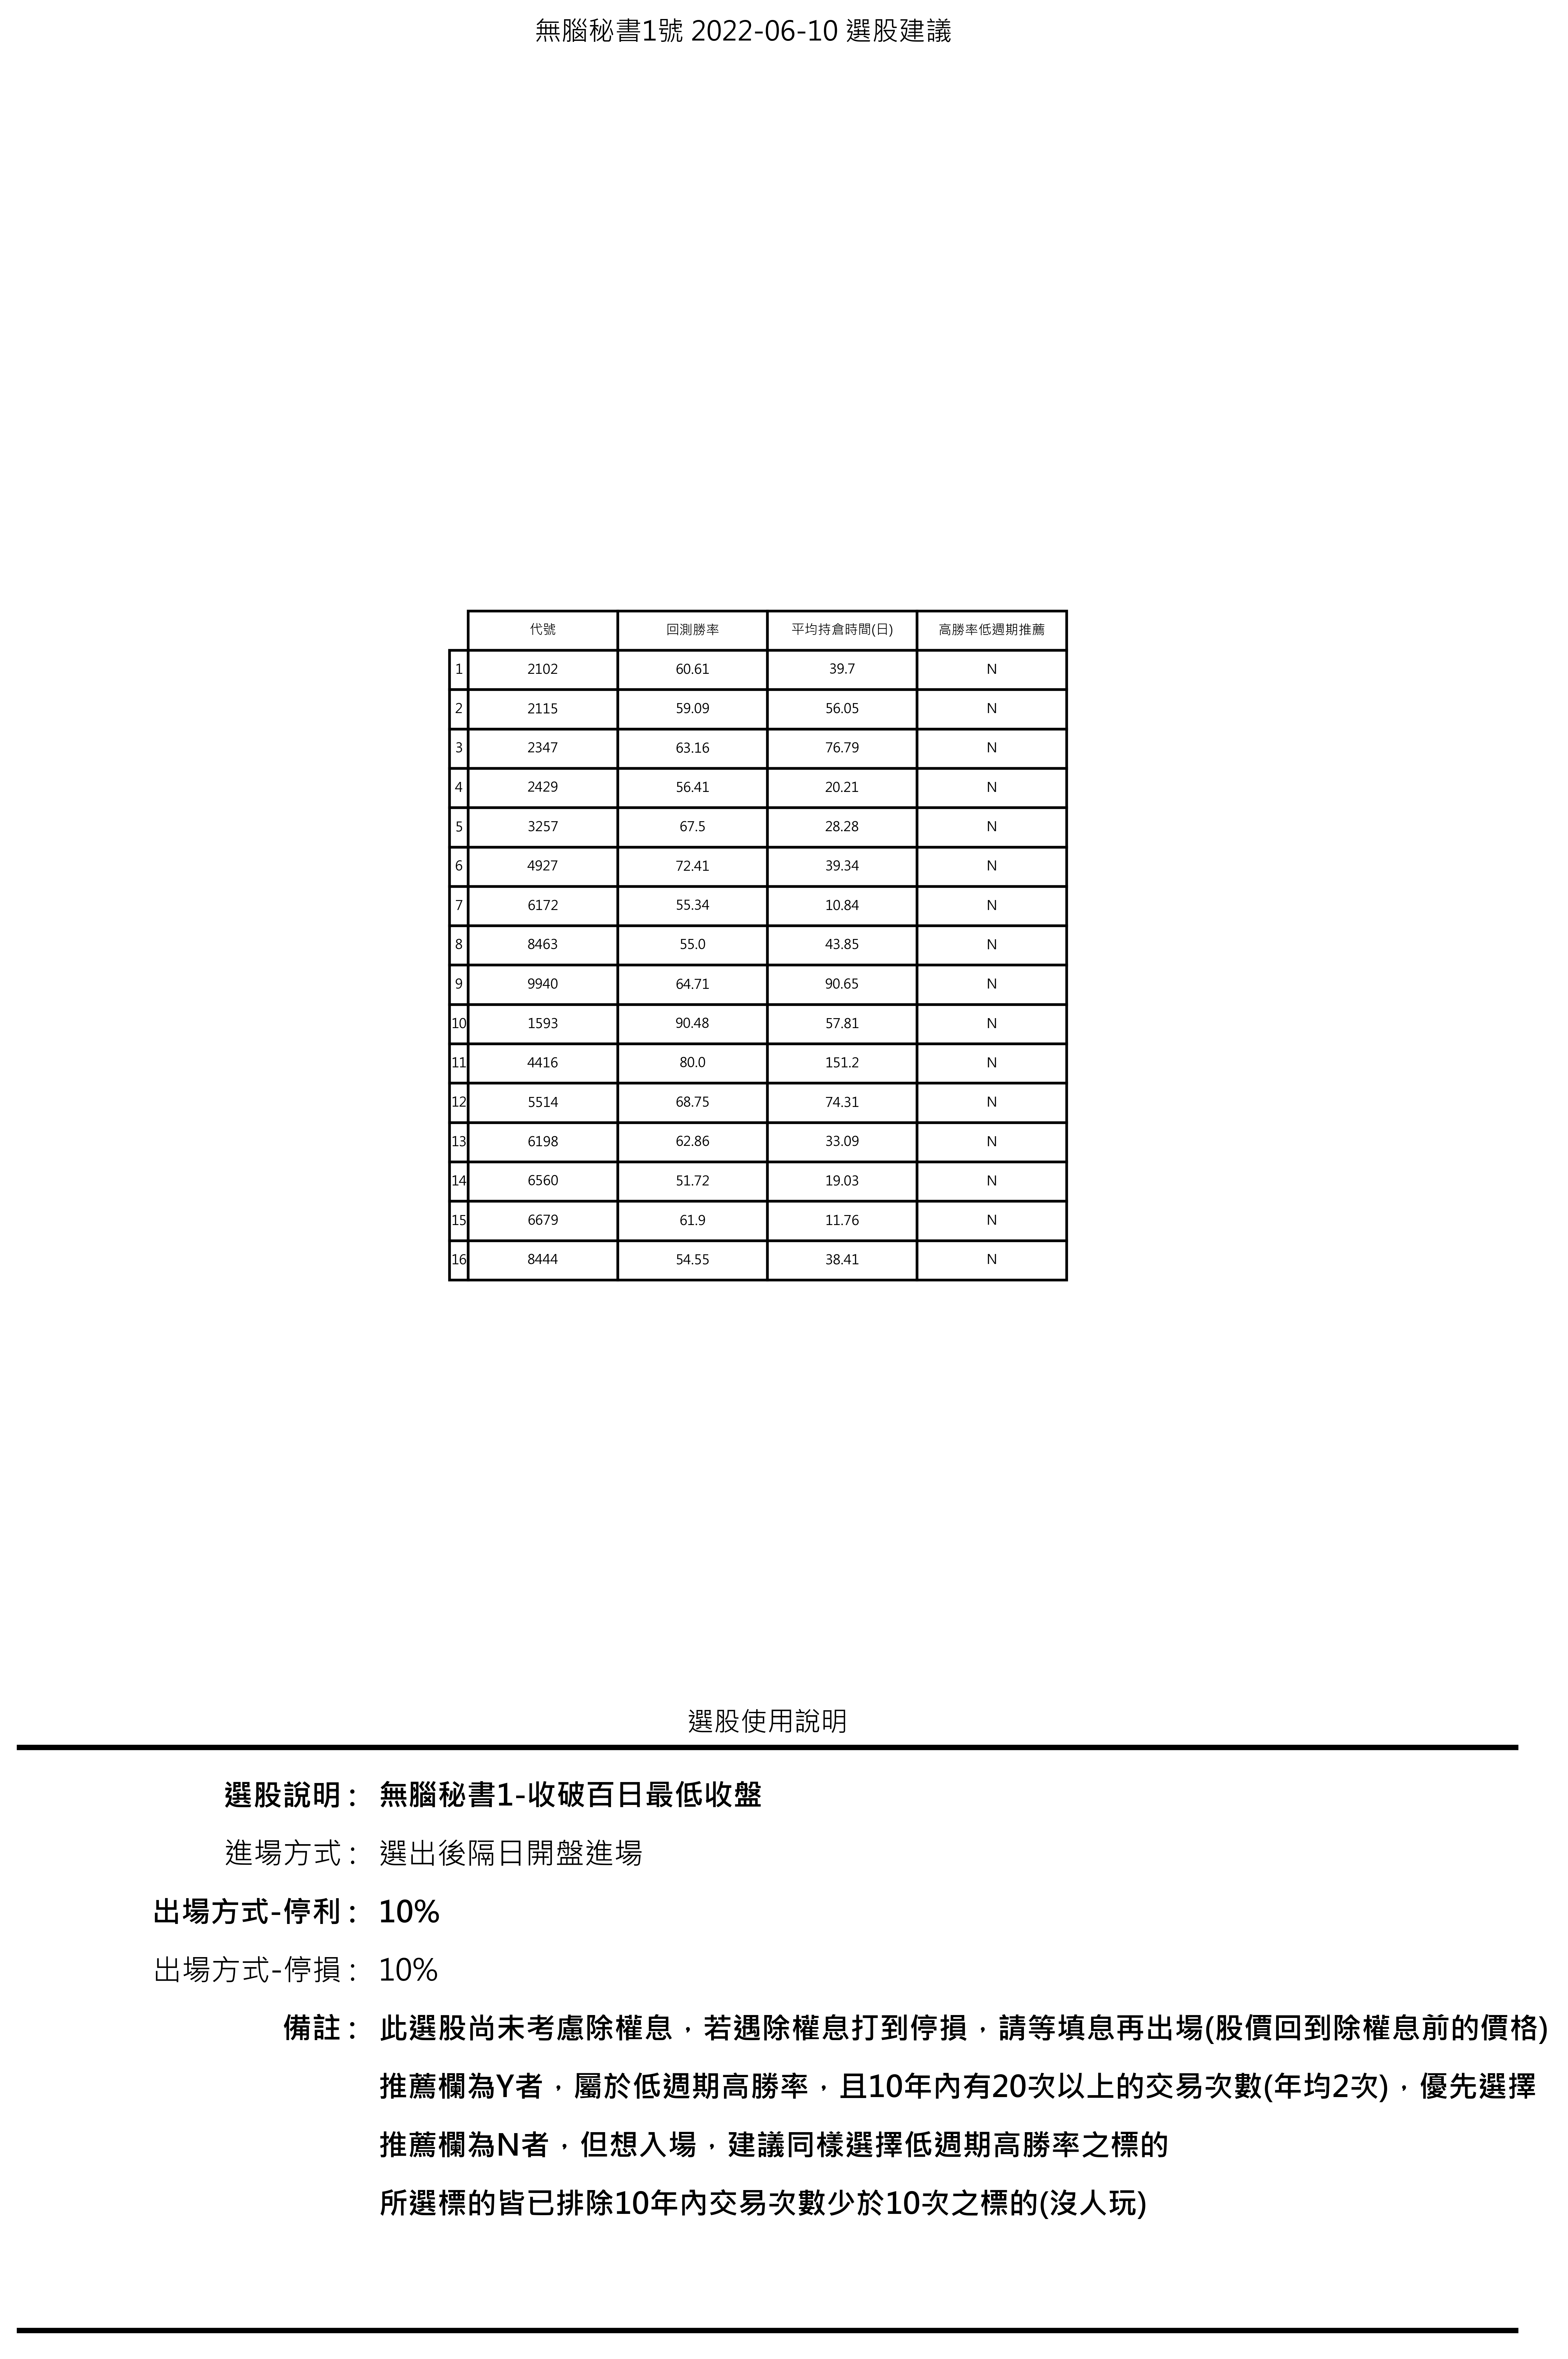

'F:\\SiteProject\\StrategyDev\\台股波段\\ResultPlot\\2022\\06\\12\\HundrenBreakoutL Stock Suggestion.jpg'

In [43]:
CreateRecommendFig(td, final_select, bt_Prob=bt_Prob, holding_p=holding_p, highProb=highProb, 
                    algo_num=1, description=description, entry_method=entry_method, take_profit_rate=10, 
                    stop_loss_rate=10, algo_name='HundrenBreakoutL')